In [15]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
df = pd.read_csv("../data_pretraitee/data_pretraite.csv", sep=';', index_col = ['Date'],parse_dates=['Date'])
df = df.drop(df.columns[0], axis=1)
df = df.sort_index(ascending=True)

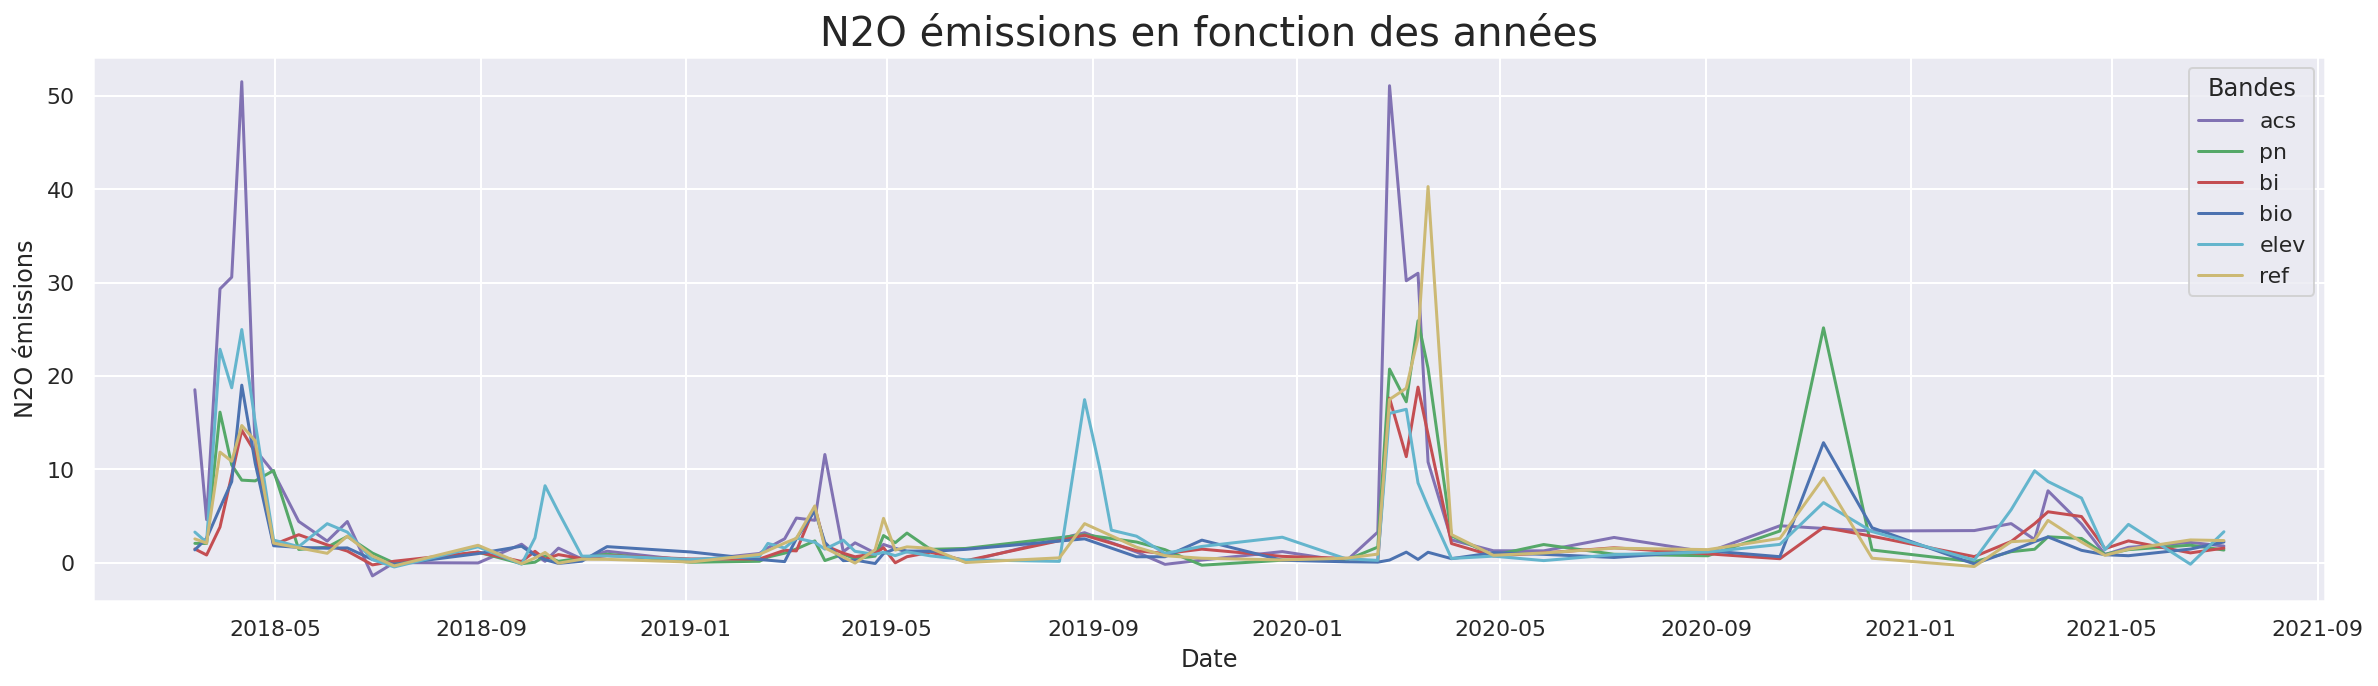

In [17]:
fig = plt.figure(figsize=(20, 5))
plt.title("N2O émissions en fonction des années", fontsize = 20)
plt.ylabel('N2O émissions', fontsize = 12) 
plt.xlabel('Date', fontsize = 12) 

markers = ['m', 'g', 'r', 'b', 'c', 'y']
for index, bande in enumerate(df.Bande.unique()):
    plt.plot(df.loc[df.Bande == bande, "N2O"], markers[index])

plt.legend(df.Bande.unique(), title="Bandes")
plt.show()

In [18]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


df2 = df[['N2O']]
moving_average(df2, 24) # prediction for the last observed day (past 24 hours)

1.6605164994665902

In [20]:
def plotMovingAverage(series, window):

    """
        series - dataframe with timeseries
        window - rolling window size 
    """
    rolling_mean = series.rolling(window=window).mean() # compute series of successive values of window size

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

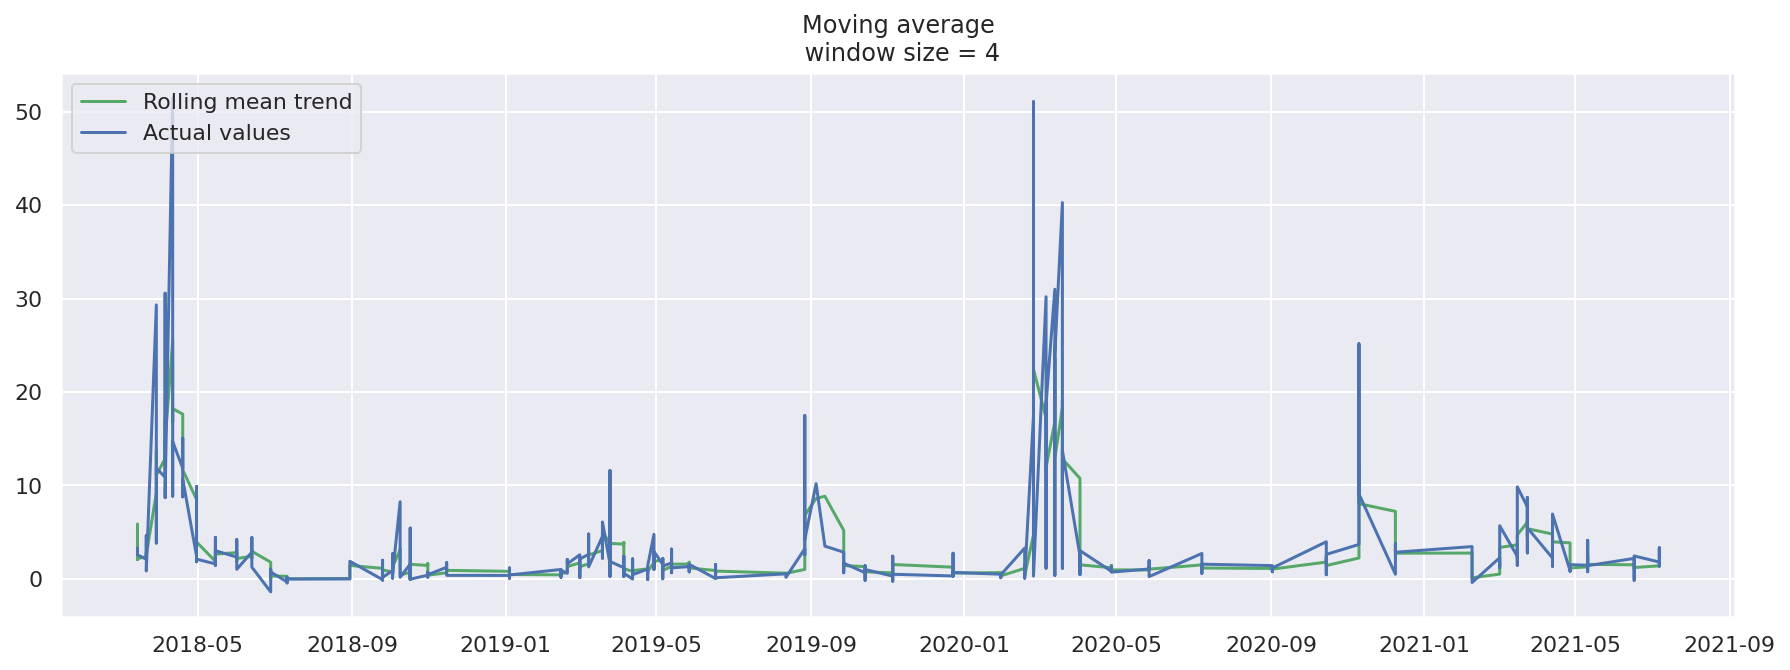

In [21]:
plotMovingAverage(df2, 4) 

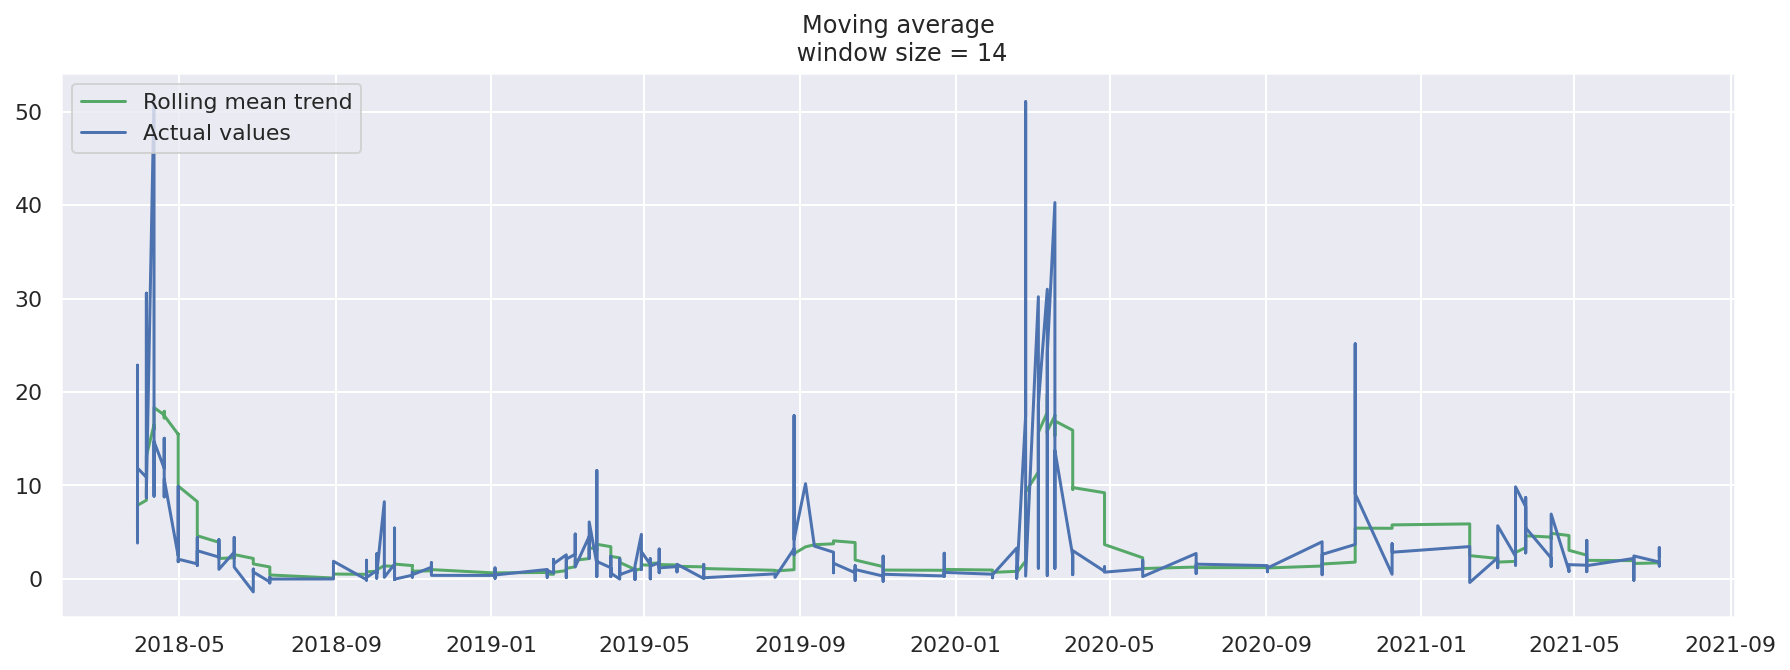

In [22]:
plotMovingAverage(df2, 14) 

In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

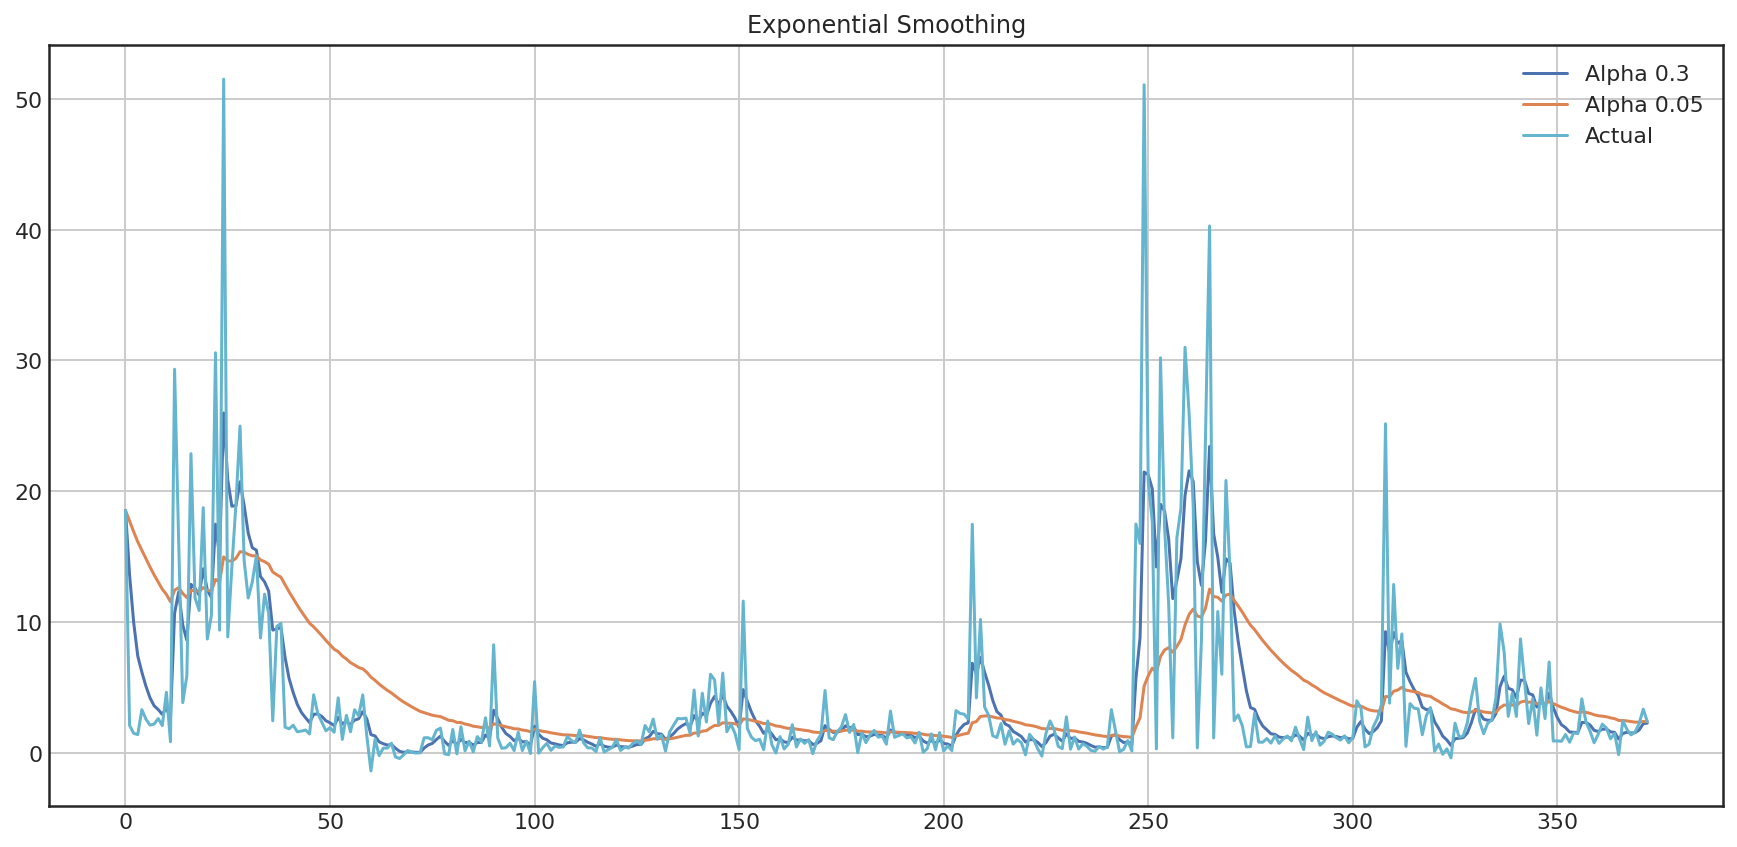

In [25]:
plotExponentialSmoothing(df2.N2O, [0.3, 0.05])

In [26]:
df2['N2O'] = df2['N2O'].apply(lambda x: 0.001 if x < 0.001 else x)

In [27]:
def incrementer_index_dataframe(dataframe, date_depart):
    """
    Prend en entrée un dataframe et une date de départ et renvoit le même dataframe
    avec les index incrémentés de 6 jours à tous les 6 index
    """
    dataframe.index = pd.date_range(start=date_depart, periods=len(dataframe)).tolist()
    for i in range(0, len(dataframe.index), 6):
        # print(i)
        break
        # dataframe.index[i] = date_depart
        # date_depart = date_depart + datetime.timedelta(days = 6)
    return dataframe

In [28]:
pd.date_range(start=df2.index.max(), periods=len(fcast2)).tolist()


NameError: name 'fcast2' is not defined

In [29]:
incrementer_index_dataframe(fcast2, df2.index.max())

NameError: name 'fcast2' is not defined

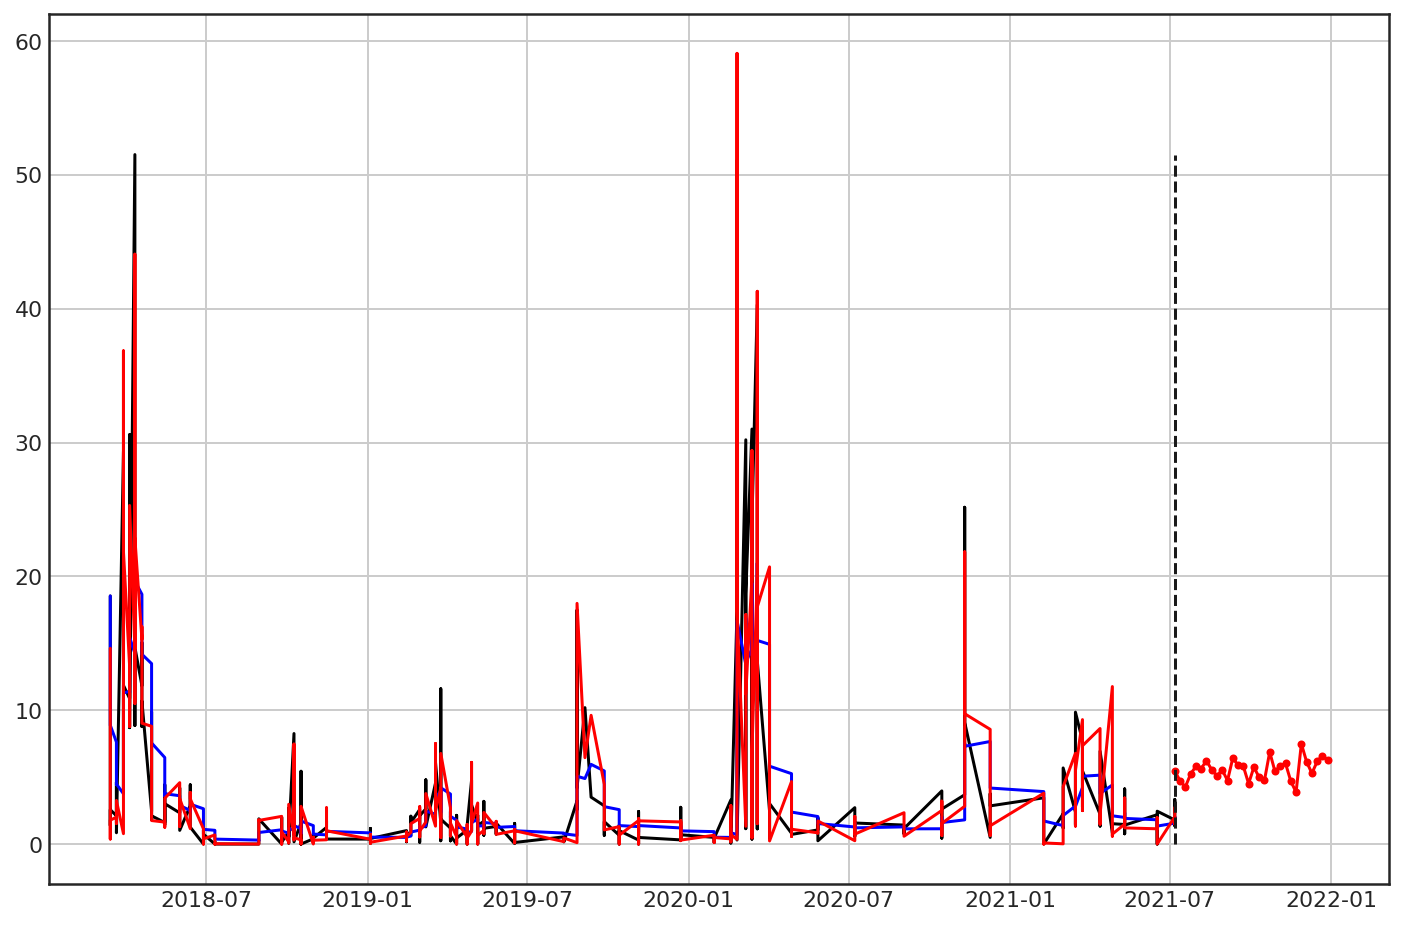

In [ ]:
# looking for implemented solution in statsmodels
from matplotlib.dates import HourLocator
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

fit1 = SimpleExpSmoothing(df2.N2O).fit(smoothing_level=0.2, optimized=False)
fit2 = ExponentialSmoothing(df2.N2O, seasonal_periods=24,trend="add", seasonal="add",\
     damped_trend=True, use_boxcox=True).fit(smoothing_level=0.8, smoothing_trend=0.2)

fcast1 = fit1.forecast(30)
fcast2 = fit2.forecast(30)
fcast2= incrementer_index_dataframe(fcast2, df2.index.max())

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(12, 8))
    plt.plot(df2.N2O, color="black")
    plt.plot(fit1.fittedvalues, color="blue")
    plt.plot(fit2.fittedvalues, color="red")
    (line2,) = plt.plot(fcast2, marker=".", color="red")
    plt.plot([df2.N2O.index[-1],df2.N2O.index[-1]], [df2.N2O.min(), df2.N2O.max()], 'k--')
    plt.axis('tight')
    plt.grid(True)


# ARIMA

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

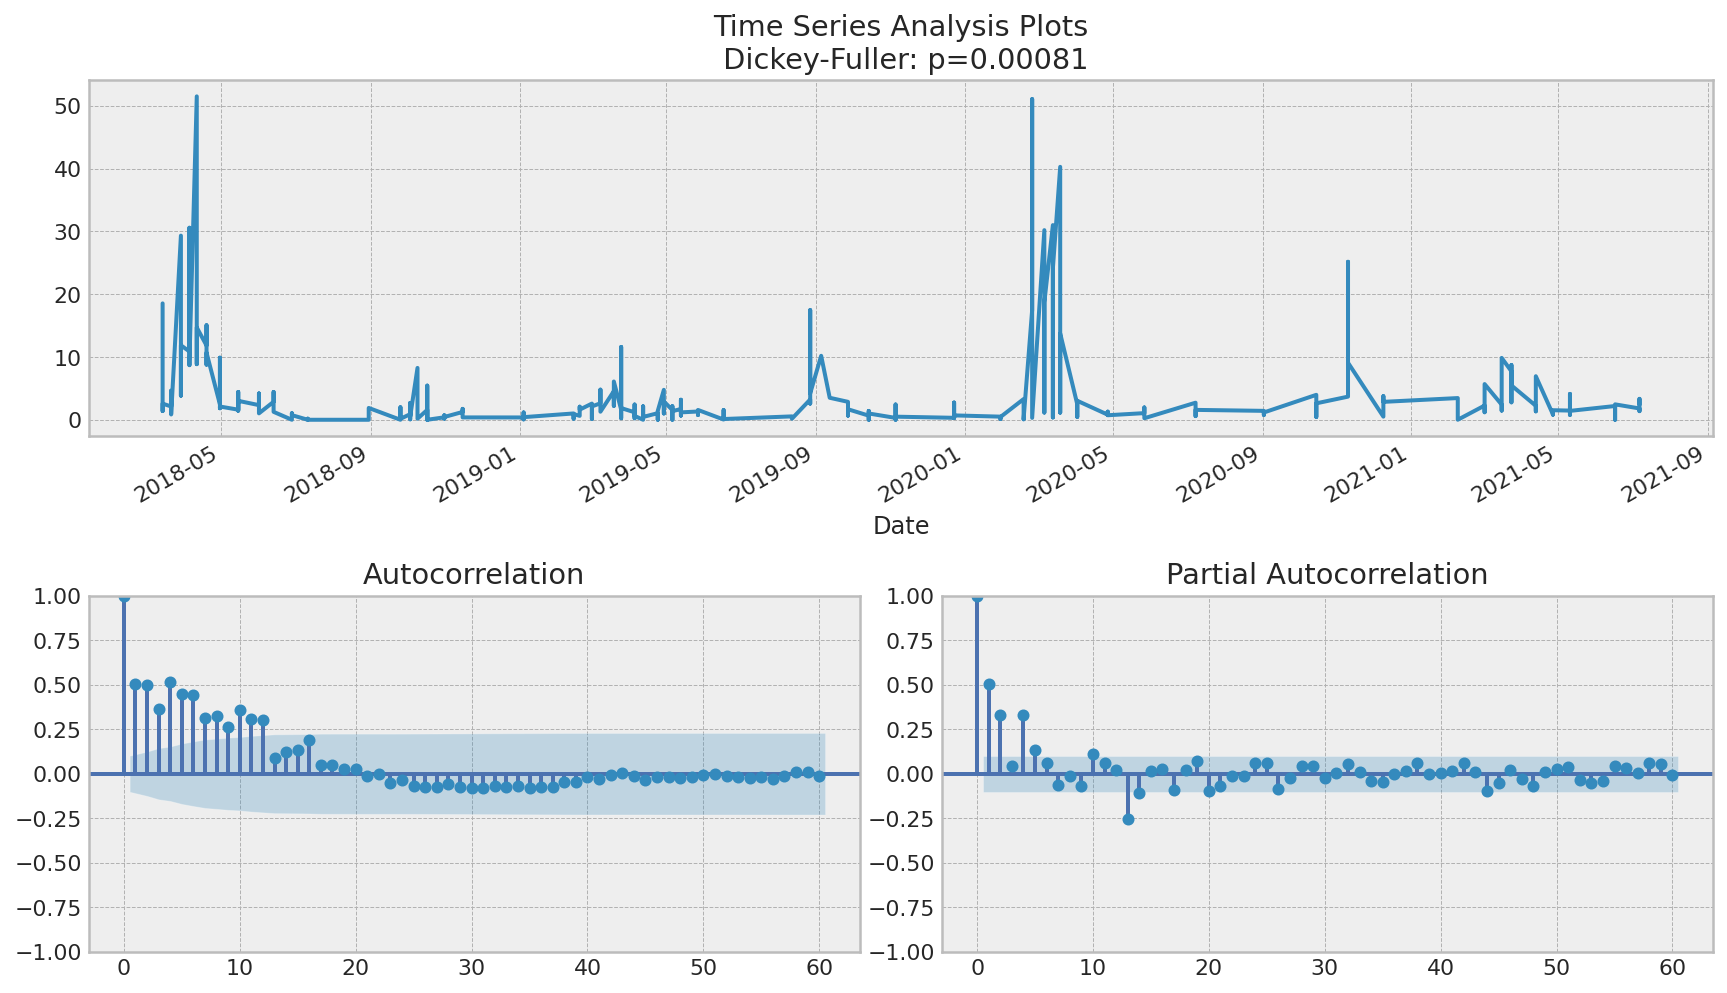

In [ ]:
tsplot(df2.N2O, lags=60)

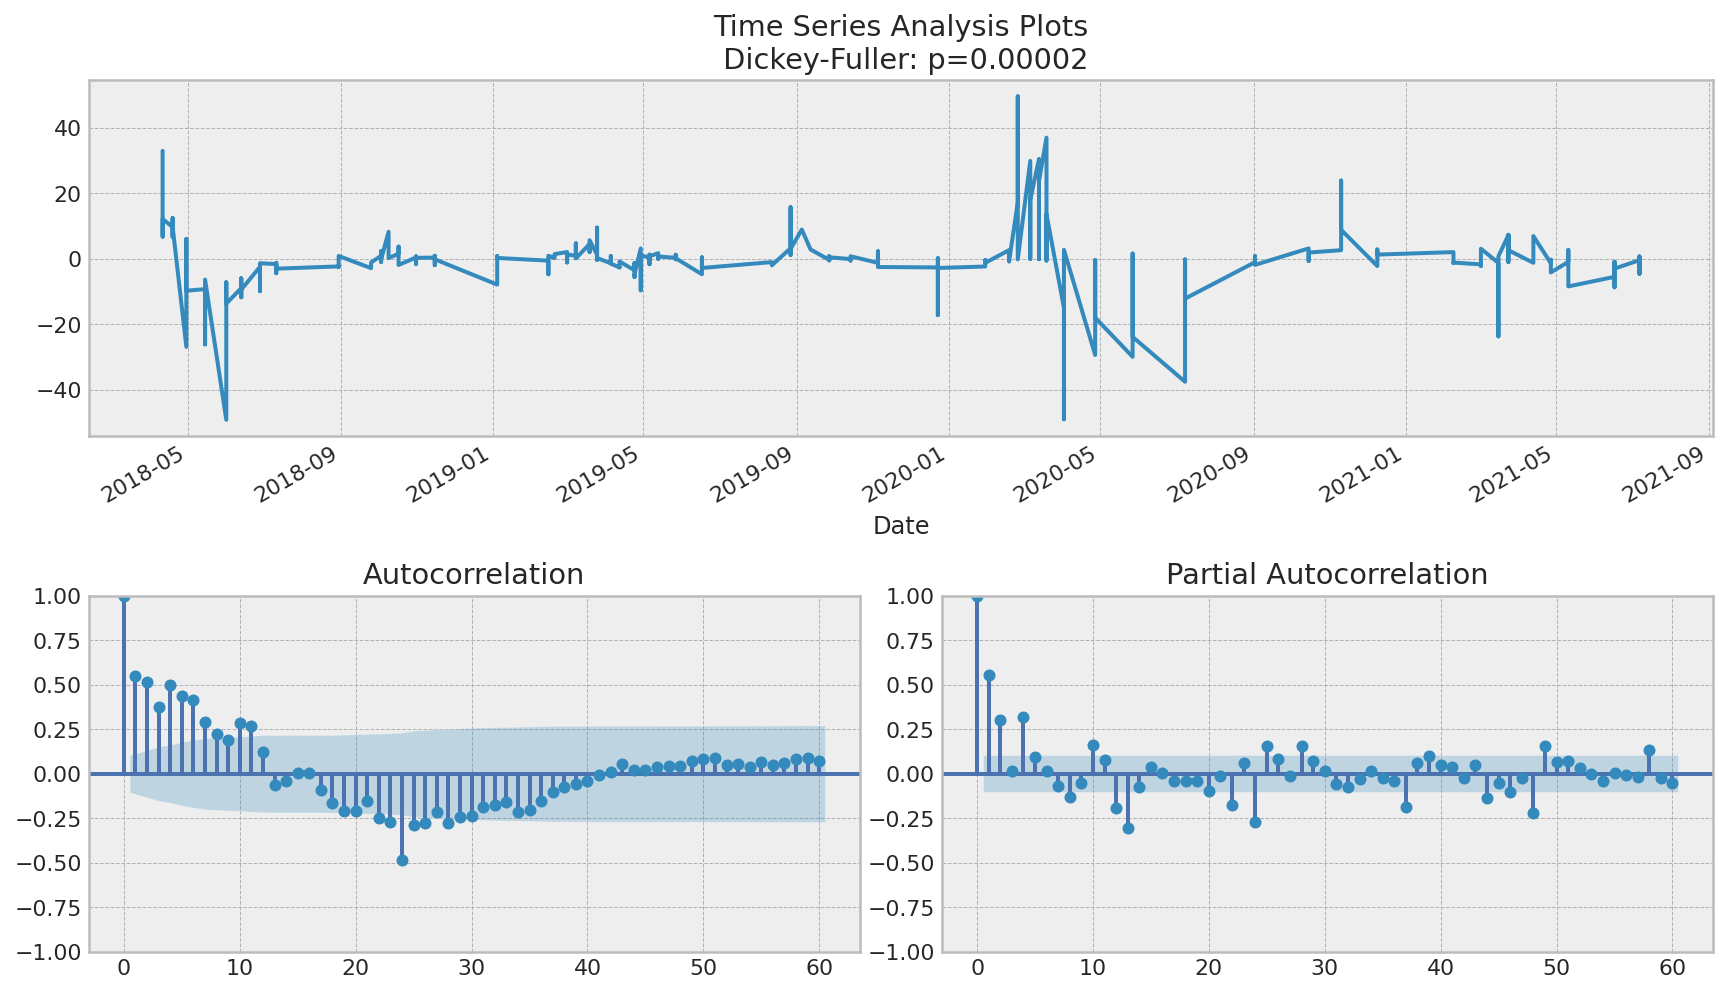

In [ ]:
N2O_diff = df2.N2O - df2.N2O.shift(24)
tsplot(N2O_diff[24:], lags=60)

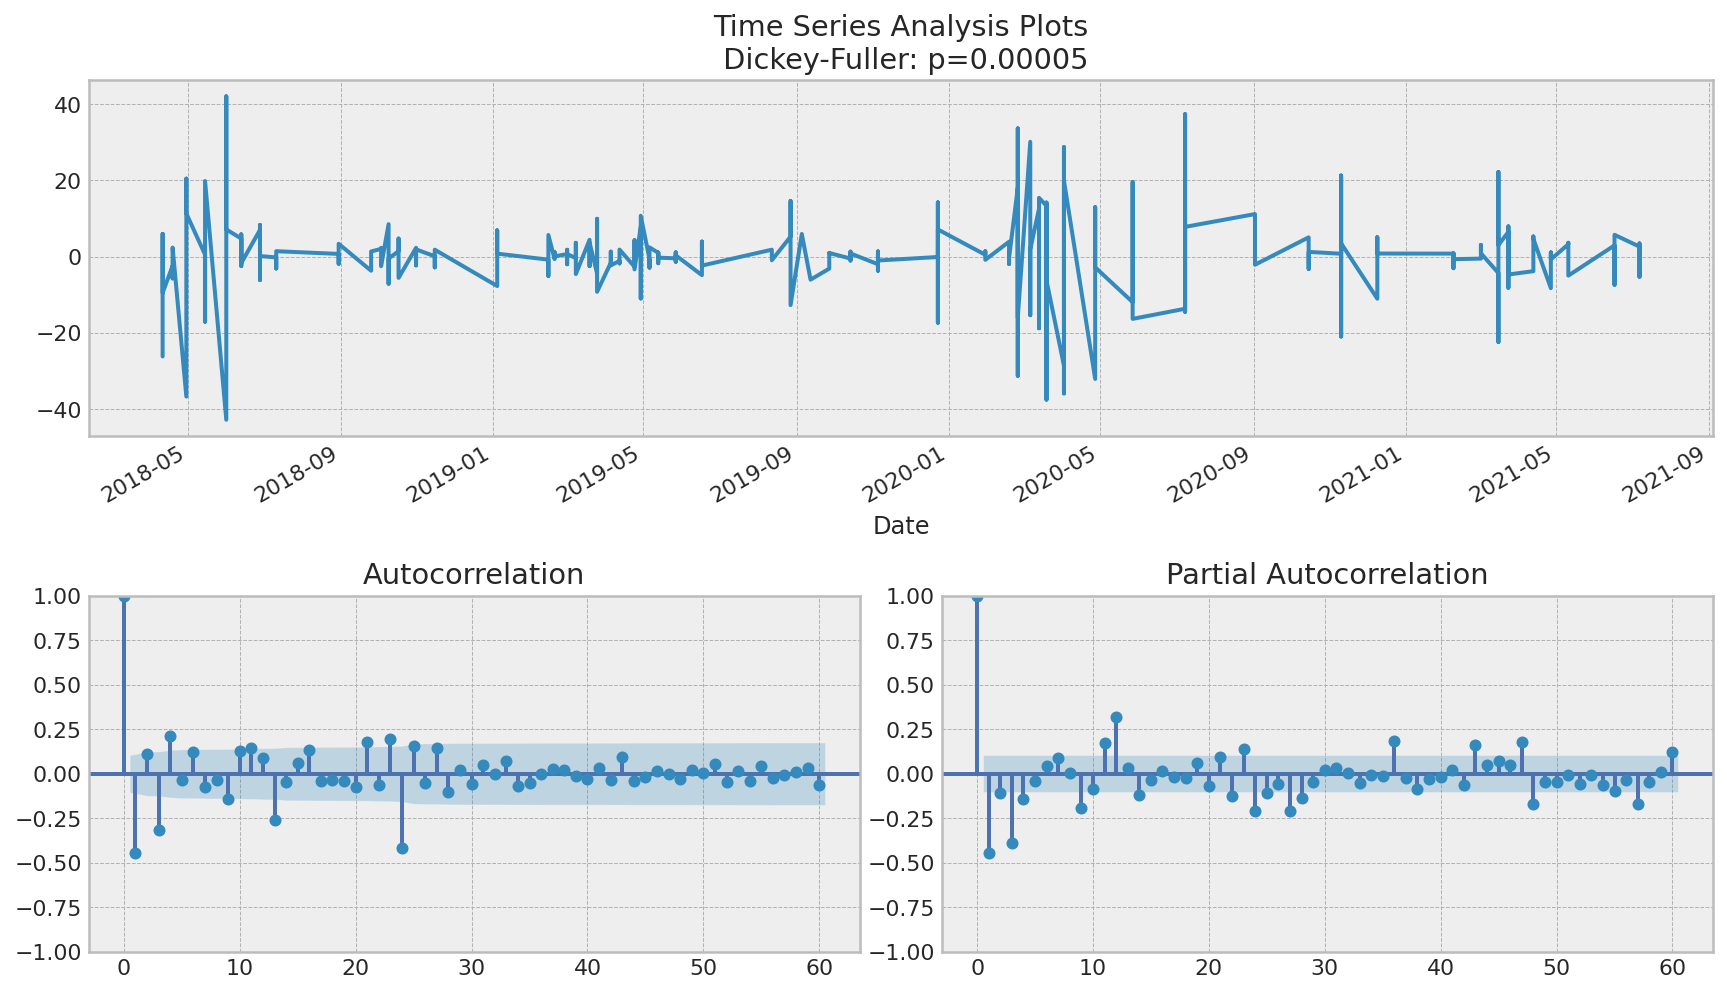

In [ ]:
N2O_diff = N2O_diff - N2O_diff.shift(1)
tsplot(N2O_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

# ARIMA-family Crash-Course

## First SARIMA model

In [ ]:
# parameter are described just below

# the following parameters are good (output of the optimization process described below)
s = 24 # season length is still 24
d,D = 1,1 # differentiation (local/season)
p,q,P,Q = (2, 3, 1, 1) # nb values (Reg), nb values (MA), nb values (Season Reg), nb values (Season MA),

model=sm.tsa.statespace.SARIMAX(df2.N2O, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [ ]:
import datetime

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    # data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast= incrementer_index_dataframe(forecast, df2.index.max())
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    # print(n_steps, forecast)
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

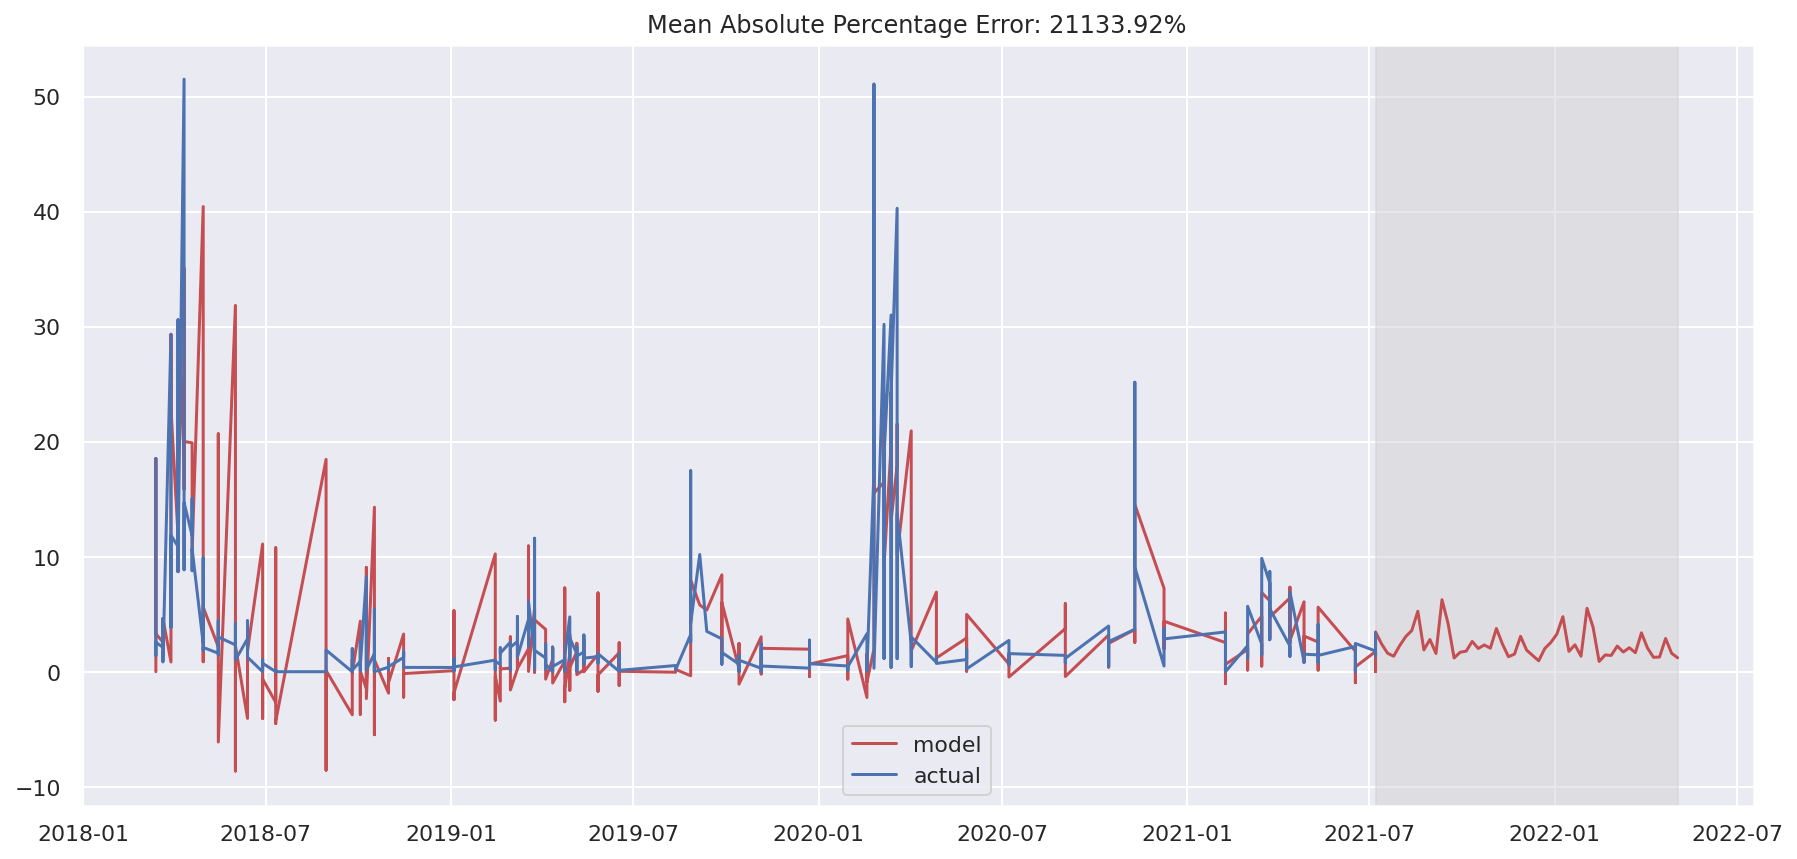

In [ ]:
plotSARIMA(df2, model, 50)

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements